#Autoencoder with MNIST
----
( 작성자: 최정우, 학번: M2018076 )

링크: https://colab.research.google.com/drive/1WU2hd0cALaF4MaVKVlcLrOwDbXzS1XU1

### 요약 : MNIST dataset 을 이용하여 간단한 Autoencoder를 학습하고 데이터를 가장 잘 표현할수 있는 Latant dimention 을 선택한다. 선택된 Latant dimension을 조정하면서 생성되는 데이터를 확인한다.

1. Autoencoder의 encoder를 거쳐 나온 representation z를 ground truth(GT) label 별로 다른색을 주어 z의 분포를 가시화 한다.

2. z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내는지 여부를 확인한다. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation z를 학습하도록 수정한다.

3. z 공간의 임의의 위치를 sampling한 후 학습된 decoder의 입력으로 주는 방식으로 generative model을 구축한다. 의미있게 만들어진 이미지는 어떤 특징을 가지고 있는지 논의한다.

4. (* 이것 이외에도 의미있는 실험들을 스스로 생각하고 수행해 본다)

## 목차
----
1. 텐서플로우와 케라스 버전확인
2. MNIST 데이터셋 불러오기
3. Autoencoder 네트워크 구성
4. 네트워크 학습
5. 학습 결과 출력
6. 각 잠재변수의 의미 실험

## 1. 텐서플로우와 케라스 버전 확인
---
텐서플로우와 케라스의 버전에 따라서 사용가능한 함수가 다르기에, 현재 사용한 버전을 표기한다.

In [0]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np

print(tf.__version__)        # 텐서플로우 버전 확인
print(tf.keras.__version__)  # 케라스 버전을 확인한다.

1.13.1
2.2.4-tf


## 2. MNIST 데이터셋 불러오기
---
###2.1. 기본 실험
---
Keras 라이브러리를 이용하여 MNIST 데이터셋을 불러오고, 데이터의 형태를 평활화 하고, 데이터 값이 0과 1사이를 가지도록 정규화한다.

###2.2. 추가 실험
---
Early stopping 과 공정한 평가를 하기위해 주어진 트레이닝 셋을 8:2로 나누어 Validation dataset 을 생성한다.

Training dataset 과 Validation dataset 만으로 학습시킨다.

학습된 네트워크를 실험할 때는 Test dataset 을 이용하여 실험을 진행한다.

In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(total_train_images, total_train_labels), (test_images, test_labels) = mnist.load_data()

# Flattening & Split validation data
total_train_images = total_train_images.reshape((len(total_train_images), np.prod(total_train_images.shape[1:]))).astype('float32')

train_images = total_train_images[:int(len(total_train_images)*0.8)]
train_labels = total_train_labels[:int(len(total_train_images)*0.8)]

val_images = total_train_images[int(len(total_train_images)*0.8):]
val_labels = total_train_labels[int(len(total_train_images)*0.8):]

test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:]))).astype('float32')

print("Train set size:", len(train_images))
print("Validation set size:", len(val_images))

print("Test set size:", len(test_images))

# Normalization
train_images = train_images/255.
val_images = val_images/255.
test_images = test_images/255.


Train set size: 48000
Validation set size: 12000
Test set size: 10000


## 3. Autoencoder 네트워크 구성
---
### 3.1. 네트워크 설명
---
Autoencoder 네트워크는 인코더 네트워크와 디코더 네트워크로 구성되어있다.
인코더 네트워크는 128 개의 노드를 가지는 fully-connected layer (ReLU activation) 와 latent_dim 의 크기를 가지는 fully-connected layer 로 구성 되어있다.
디코더 네트워크는 128 개의 노드를 가지는 fully-connected layer (ReLU activation) 와 784개의 크기를 가지는 fully-connected layer (Sigmoid activation) 로 구성 되어있다.
데이터를 이미 평활화 시켰기 때문에, Flatten layer 와 Reshape layer 를 비활성화 하였다.

Keras Model 의 경우 call 함수를 구현해주면 Keras에서 제공되는 compile과 fit을 사용 할 수 있다.
초기화 단계에서 선언한 inference_net 과 generative_net을 이용하여 call 함수를 구현한다.

encode 함수와 decode 함수는 각 네트워크의 inference (predict)로 구현하여, 훈련된 weight 로부터 인코딩된 값 또는 복원된 값을 구하는 데에 각각 사용된다.

In [0]:
class AE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(AE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.models.Sequential([
            #layers.Flatten(input_shape=(28, 28, 1)),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.latent_dim)
        ])

        self.generative_net = tf.keras.models.Sequential([
            layers.InputLayer(input_shape=(self.latent_dim,)),        
            #layers.Lambda(self.latent_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(28*28, activation='sigmoid'),
            #layers.Reshape((28, 28, 1))
        ])    

    def encode(self, x):
        return self.inference_net.predict(x)

    def decode(self, z):
        return self.generative_net.predict(z)

    def call(self, inputs):
        return self.generative_net(self.inference_net(inputs))
    

## 4. 네트워크 학습
---
### 4.1. 학습 알고리즘
---
본 네트워크는 데이터 자신을 인코딩 네트워크로 인코딩한 후 다시 자기자신을 디코딩하여 복원하는 네트워크이다.
따라서 복원된 값과 입력 값의 차이는 Mean squared error (MSE)를 이용하여 구한다.
MSE 수식은 다음과 같다.

$$\frac 1 {N} \sum_{i=1}^N (X_i - \hat{X_i}) ^2$$

네트워크를 최적화 하는 방법은 Adam 최적화 방법을 사용한다.
Adam 최적화는 다음과 같은 수식으로 네트워크의 가중치를 업데이트한다.

$$ (m_t)i = \beta_1 (m{t-1})_i + (1-\beta_1)(\nabla L(W_t))_i,\ (v_t)i = \beta_2 (v{t-1})_i + (1-\beta_2)(\nabla L(W_t))_i^2, $$

$$ (W_{t+1})_i = (W_t)_i - \alpha \frac{\sqrt{1-(\beta_2)_i^t}}{1-(\beta_1)_i^t}\frac{(m_t)_i}{\sqrt{(v_t)_i}+\varepsilon}. $$

Kingma et al. [1] 에서 제안되었고, 논문에서 제안된 초기값은 다음과 같다.

$$\beta_1 = 0.9, \beta_2 = 0.999, \varepsilon = 10^{-8}$$ 

[1] D. Kingma, J. Ba.
    [Adam: A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980).
    *International Conference for Learning Representations*, 2015.

### 4.2. 잠재 변수
---
본 과제에서는 각 데이터로부터 카테고리 간의 특징을 잘 표현하면서 가장 작게 인코딩하는 것을 의미있게 보고 있다.
잠재변수의 크기를 2에서 부터 11까지 변화 시켜, 총 10개의 다른 네트워크를 만들어서 동시에 학습시킨다.
이 때, 배치사이즈는 32를 사용하고, Epoch으로는 최대 30만큼 학습 시켰다.
앞서 전체 Train dataset로 부터 데이터를 나누어서 Train dataset으로 학습하고 Validation dataset 검증하고 Keras 에서 제공되는 Ealry stopping 을 이용해서 학습에 진전이 없으면 조기 종료시킨다.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto') # 조기종료 콜백함수 정의

network = []
for latent_dim in range(2,12):
    print("Train", latent_dim, "latent dimension autoencoder")
    network.append(AE(latent_dim))
    network[-1].compile(optimizer='adam',
                       loss='mse',         # Mean squared error
                       metrics=['mae'])    # mean absolute error
    network[-1].fit(train_images, train_images,
                        epochs=30,
                        batch_size=32,
                        validation_data=(val_images, val_images),
                        callbacks=[early_stopping])

Train 2 latent dimension autoencoder
Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 10s 204us/sample - loss: 0.0564 - mean_absolute_error: 0.1276 - val_loss: 0.0492 - val_mean_absolute_error: 0.1134
Epoch 2/30
48000/48000 [==============================] - 9s 190us/sample - loss: 0.0479 - mean_absolute_error: 0.1104 - val_loss: 0.0463 - val_mean_absolute_error: 0.1080
Epoch 3/30
48000/48000 [==============================] - 9s 190us/sample - loss: 0.0460 - mean_absolute_error: 0.1065 - val_loss: 0.0451 - val_mean_absolute_error: 0.1057
Epoch 4/30
48000/48000 [==============================] - 10s 199us/sample - loss: 0.0450 - mean_absolute_error: 0.1043 - val_loss: 0.0442 - val_mean_absolute_error: 0.1034
Epoch 5/30
48000/48000 [==============================] - 10s 203us/sample - loss: 0.0442 - mean_absolute_error: 0.1026 - val_loss: 0.0436 - val_mean_absolute_error: 0.1022
Epoch 6/30
48000/48000 [==========================

## 5. 학습 결과 출력
---
### 5.1. 잠재변수의 크기에 따른 복원이미지 시각화
---
랜덤하게 각 10개의 샘플을 선택하여 인코딩하고 복원해 잠재 변수 z 에 따라서 어떤 결과가 복원되는지 비교 할 수 있도록 시각화를 하였다.
당연히, 잠재변수가 클수록 원본에 가깝게 복원되는것을 확인 할 수 있었다.

(훈련에 사용되지 않은 Test dataset 을 이용한다.)

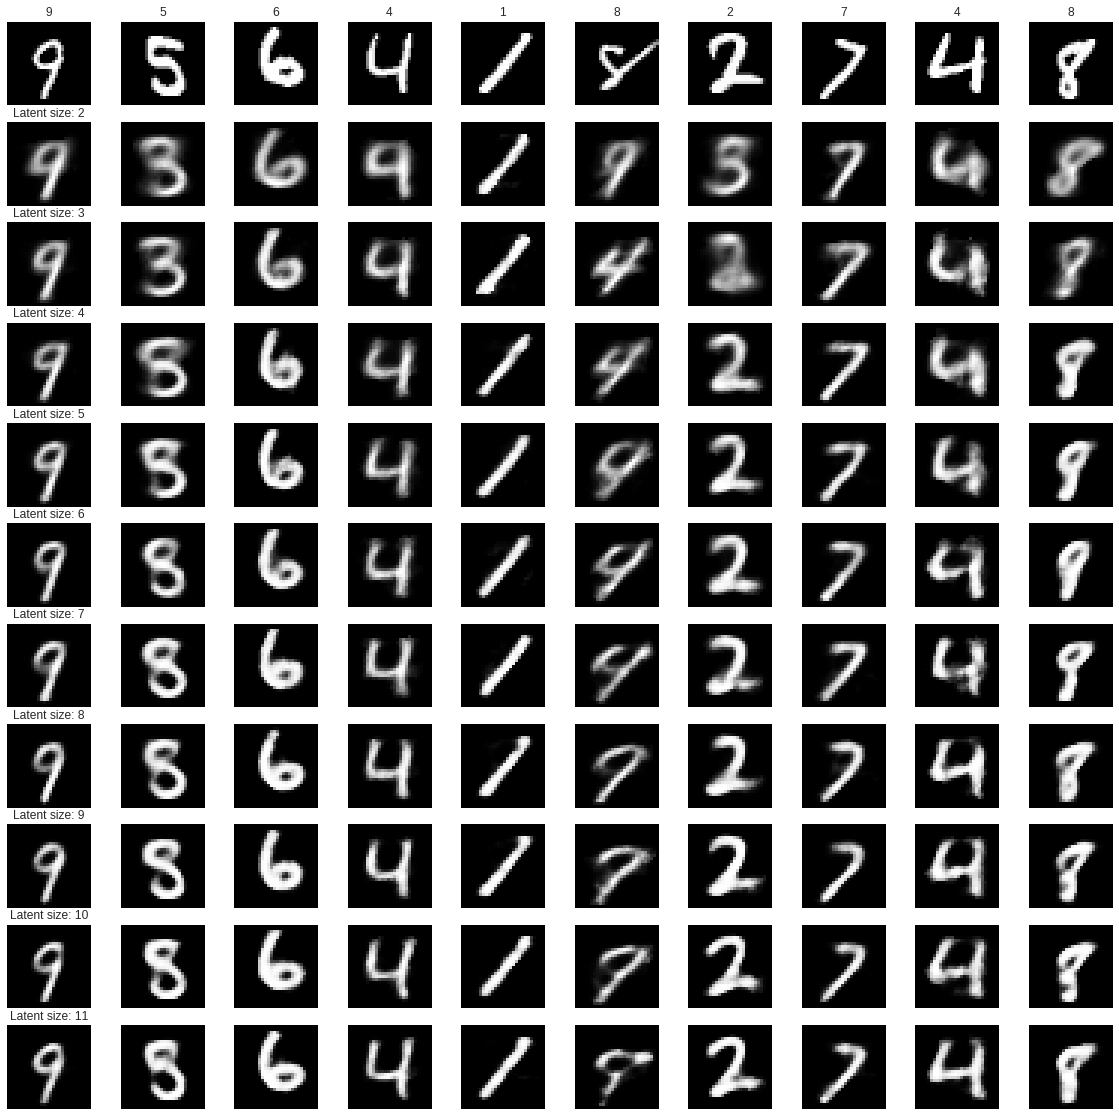

In [0]:
# 재생성된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
import random

# 가시화할 데이터셋 생성
encoded_img_list = []
decoded_img_list = []
for i in range(len(network)):
    encoded_img_list.append(network[i].encode(test_images))
    decoded_img_list.append(network[i].decode(encoded_img_list[i]))
    
# 10개의 예시 출력 
n = 10
plt.figure(figsize=(2*n, 2* len(network)))

# 랜덤 인덱스 생성
randlist = []
while len(randlist)<n:
    temp = random.randint(0,test_images.shape[0])
    if not temp in randlist:
        randlist.append(temp)

for i, idx in enumerate(randlist):
    # display original
    ax = plt.subplot(len(decoded_img_list)+1, n, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(str(test_labels[idx]))
    
    # display reconstruction
    for j, decoded_imgs in enumerate(decoded_img_list):
        
        ax = plt.subplot(len(decoded_img_list)+1, n, i + 1 + n*(j+1))
        plt.imshow(decoded_imgs[idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.title.set_text("Latent size: "+str(network[j].latent_dim))
    
plt.show()

### 5.2. 네트워크 인코딩 성능 시각화
---
#### 5.2.1. PCA
---
Test dataset을 인코딩한 잠재변수 z를 카테고리 별로 색을 다르게 표기하여 PCA를 이용해 2차원에 투영하여 가시화 하였다.
PCA 에서는 잘 분류 된 것이 파악되지 않아 t-SNE를 이용하여 다시 시각화 해보았다.

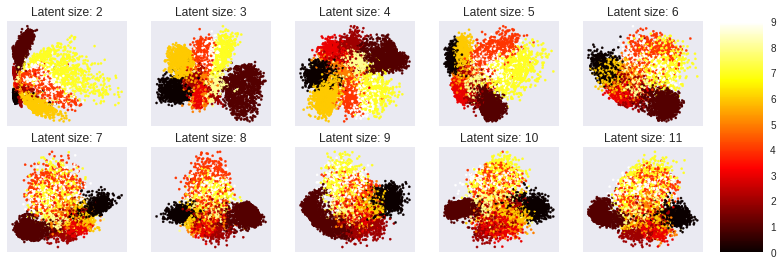

In [0]:
from sklearn.decomposition import PCA

n = len(encoded_img_list)
plt.figure(figsize=(12, 4))

for i, en_list in enumerate(encoded_img_list):
    ax = plt.subplot(2, 5, i+1)
    X = PCA(n_components=2).fit_transform(en_list)
    plt.scatter(X[:, 0], X[:, 1], s=5, c=test_labels, cmap=plt.cm.hot)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text("Latent size: "+str(network[i].latent_dim))

plt.subplots_adjust(bottom=0.1, right=0.93, top=0.9)
cax = plt.axes([0.95, 0.1, 0.05, 0.8])
plt.colorbar(cax=cax)
plt.show()    


#### 5.2.1. t-SNE
---
Test dataset을 인코딩한 잠재변수 z를 카테고리 별로 색을 다르게 표기하여 t-SNE 이용해 2차원에 투영하여 가시화 하였다.
Latent size 가 6이 되었을때 군집이 형성되는것이 확인 된다.
실험적으로 최소한 6 크기의 잠재변수를 가질 때 의미 있는 인코딩을 할 수 있음을 알수있다.

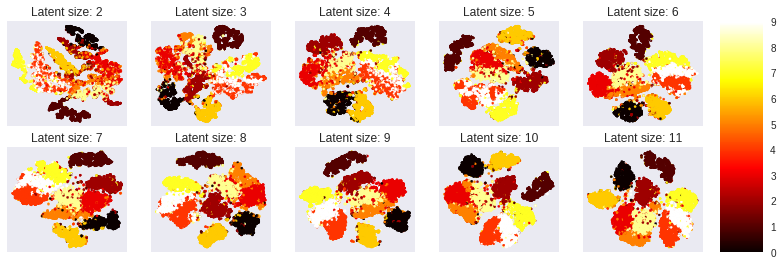

In [0]:
from sklearn.manifold import TSNE

n = len(encoded_img_list)
plt.figure(figsize=(12, 4))

for i, en_list in enumerate(encoded_img_list):
    ax = plt.subplot(2, 5, i+1)
    X = TSNE(n_components=2).fit_transform(en_list)
    plt.scatter(X[:, 0], X[:, 1], s=5, c=test_labels, cmap=plt.cm.hot)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text("Latent size: "+str(network[i].latent_dim))

plt.subplots_adjust(bottom=0.1, right=0.93, top=0.9)
cax = plt.axes([0.95, 0.1, 0.05, 0.8])
plt.colorbar(cax=cax)
plt.show() 

## 6. 각 잠재변수의 의미 실험
---
### 6.1. 랜덤 샘플링 및 UI 생성
---
Test dataset 에서 랜덤하게 하나의 이미지를 추출하여 인코딩 시킨 뒤, 출력된 잠재변수를 이용하여 슬라이더의 초기치를 설정한다.
각 슬라이더의 최대값과 최저값은 각 잠재 변수별로 전체 Test dataset의 최대 값과 최소 값의 $\pm 10\%$ 만큼의 마진을 더 적용하여 설정하였다.

cf. colab 특성상 실시간 변화가 적용되지 않아서, 상단의 슬라이더를 움직이고 다음 코드를 실행시키면 변화된 값 디코딩하여 시각화 하게 코드를 작성 하였다.

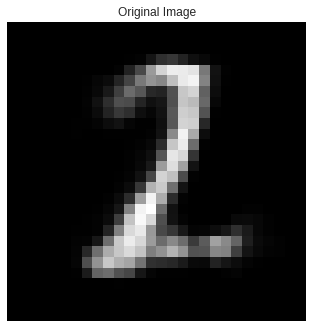

초기값: [ 6.934305  -4.070794  -5.093342   6.0041766 10.232446   4.4103327]


Output()

In [0]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import random

lval = 6
rand_idx = random.randint(0,test_images.shape[0])
ax = plt.subplot(1, 1, 1)
ax.title.set_text("Original Image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
plt.axis('off')
plt.show()
print("초기값:", encoded_img_list[lval-2][rand_idx])

max_val = np.amax(encoded_img_list[lval-2], axis=0)
min_val = np.amin(encoded_img_list[lval-2], axis=0)

a = widgets.FloatSlider(min=min_val[0]*1.1, max=max_val[0]*1.1, step=0.01, value=encoded_img_list[lval-2][rand_idx][0])
b = widgets.FloatSlider(min=min_val[1]*1.1, max=max_val[1]*1.1, step=0.01, value=encoded_img_list[lval-2][rand_idx][1])
c = widgets.FloatSlider(min=min_val[2]*1.1, max=max_val[2]*1.1, step=0.01, value=encoded_img_list[lval-2][rand_idx][2])
d = widgets.FloatSlider(min=min_val[3]*1.1, max=max_val[3]*1.1, step=0.01, value=encoded_img_list[lval-2][rand_idx][3])
e = widgets.FloatSlider(min=min_val[4]*1.1, max=max_val[4]*1.1, step=0.01, value=encoded_img_list[lval-2][rand_idx][4])
f = widgets.FloatSlider(min=min_val[5]*1.1, max=max_val[5]*1.1, step=0.01, value=encoded_img_list[lval-2][rand_idx][5])

ui = widgets.VBox([a, b, c, d, e, f])
def func(a, b, c, d, e, f):
    return np.array([a, b, c, d, e, f]).astype(np.float32)

out = widgets.interactive_output(func, {'a': a, 'b': b, 'c': c, 'd': d, "e": e, "f": f})

display(ui, out)

### 6.2. 첫번째 잠재변수의 의미 분석
---
#### 6.2.1. 증가
---
두께가 두꺼워지고 2의 모양에서 밑의 막대가 사라지고 3의 모양으로 변한다.

변화된 값: [[19.65787   -4.070794  -5.093342   6.0041766 10.232446   4.4103327]]


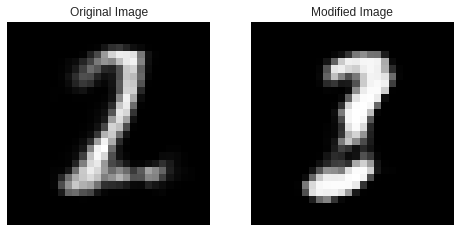

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)

ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

#### 6.2.1. 감소
---
회전이 일어나고 세로로 기다랗던 숫자가 낮아지고, 누운 6이나 9에 가까운 모양으로 변한다.

변화된 값: [[-13.40213    -4.070794   -5.093342    6.0041766  10.232446    4.4103327]]


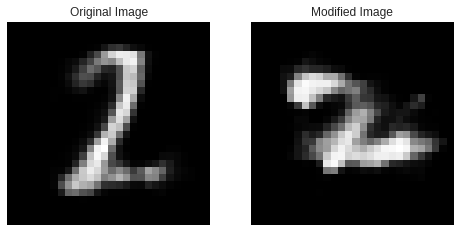

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

### 6.3. 두번째 잠재변수의 의미 분석
---
#### 6.3.1. 증가
---
퍼져 있는 부분들이 뭉치고 6에 가까운 형태가 된다.

변화된 값: [[ 6.92787 21.42839 -5.08751  5.9983  10.23416  4.40761]]


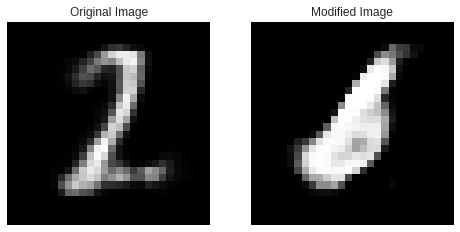

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

#### 6.3.1. 감소
---
둥근 글씨체가 각지게 바뀌고 수평 직선이 진해진다.

변화된 값: [[  6.92787 -15.14161  -5.08751   5.9983   10.23416   4.40761]]


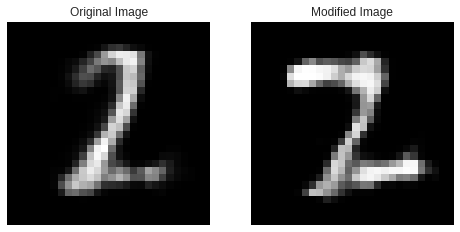

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

### 6.4. 세번째 잠재변수의 의미 분석
---
#### 6.4.1. 증가
---
두께가 얇아진다.

변화된 값: [[ 6.92787 -4.07161  6.51249  5.9983  10.23416  4.40761]]


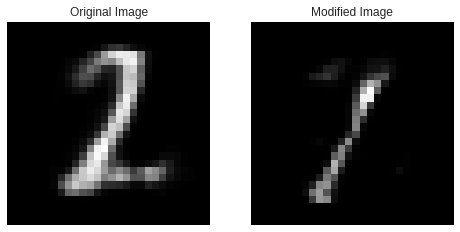

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

#### 6.4.1. 감소
---
두께가 두꺼워진다.

변화된 값: [[  6.92787  -4.07161 -24.65751   5.9983   10.23416   4.40761]]


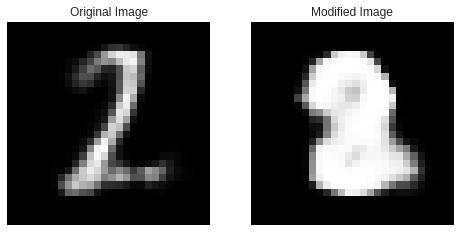

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

### 6.5. 네번째 잠재변수의 의미 분석
---
#### 6.5.1. 증가
---
2로 구분할수 있는 밑의 가로선이 사라지고 9또는 7과 같은 형태로 변한다.

변화된 값: [[ 6.92787 -4.07161 -5.08751 25.1083  10.23416  4.40761]]


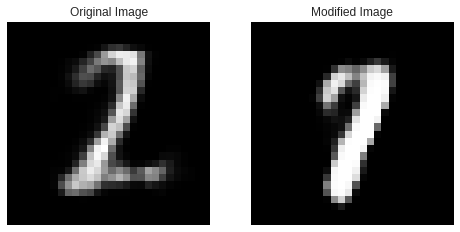

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

#### 6.5.1. 감소
---
2의 구성성분중 수평 성분이 강해진다.

변화된 값: [[ 6.92787 -4.07161 -5.08751 -4.8317  10.23416  4.40761]]


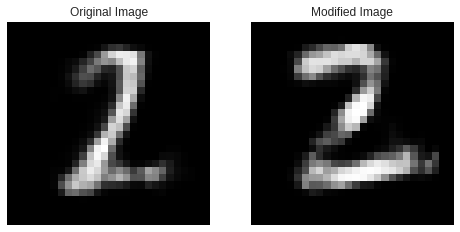

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

### 6.6. 다섯번째 잠재변수의 의미 분석
---
#### 6.6.1. 증가
---
대각선 성분과 밑의 수평 성분이 강해진다.

변화된 값: [[ 6.92787 -4.07161 -5.09751  6.0083  27.09416  4.40761]]


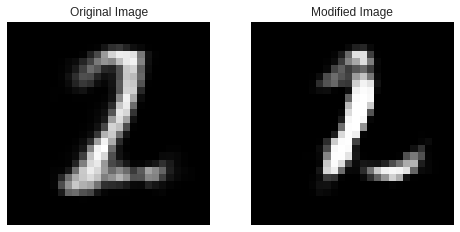

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

#### 6.6.1. 감소
---
굴곡의 반경이 커지고, 0에 가깝게 변한다.

변화된 값: [[  6.92787  -4.07161  -5.08751   5.9983  -17.64584   4.40761]]


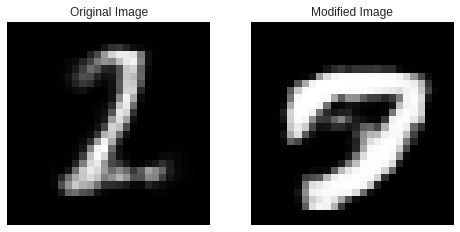

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

### 6.7. 여섯번째 잠재변수의 의미 분석
---
#### 6.7.1. 증가
---
시계방향으로 기운 대각선 성분이 매우 강해지도 1에 가까워진다.

변화된 값: [[ 6.92787 -4.07161 -5.09751  5.9983  10.23416 14.37761]]


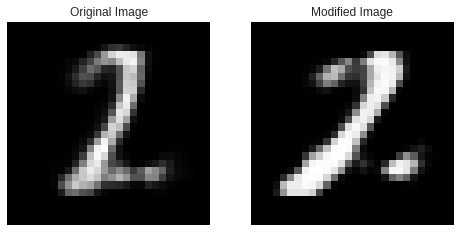

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

#### 6.7.1. 감소
---
반시계 방향으로 숫자가 기울고, 3또는 1에 가까워진다.

변화된 값: [[  6.92787  -4.07161  -5.09751   5.9983   10.23416 -26.81239]]


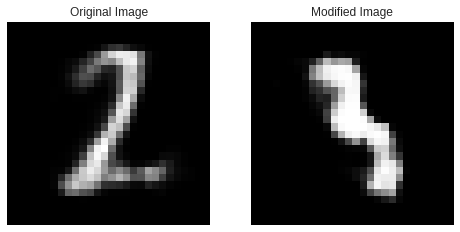

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
display(ui, out)

### 6.8. 다른 숫자 만들기
---
잠재변수의 특성을 이용하여 2의 기본 인코딩을 6으로 변형 시킬수있다.

변화된 값: [[  9.13787  21.42839 -23.26751   4.7783    0.19416 -25.55239]]


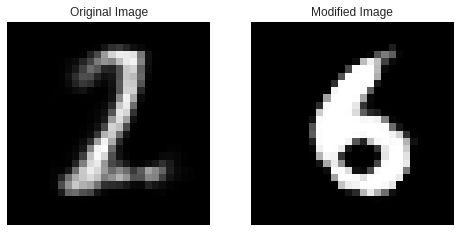

Output()

In [0]:
changed_value = np.array([[a.value, b.value, c.value, d.value, e.value, f.value]]).astype(np.float32)
print("변화된 값:", changed_value)

changed_decoded_img = network[lval-2].decode(changed_value)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img_list[lval-2][rand_idx].reshape(28, 28))
ax1.title.set_text("Original Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(changed_decoded_img.reshape(28, 28))
ax2.title.set_text("Modified Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()

display(ui, out)